In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%env XLA_PYTHON_CLIENT_MEM_FRACTION=.8



env: XLA_PYTHON_CLIENT_MEM_FRACTION=.8


In [3]:
not True

False

In [4]:
#!/usr/bin/python
#
# Copyright 2022 DeepMind Technologies Limited
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

"""Energy-based training of a flow model on an atomistic system."""
import numpy as np
from bgmat.experiments import   augmented_monatomic_water_config, augmented_lennard_jones_config
from bgmat.experiments.augmented_monatomic_water_config import QUIGLEY_DENSITY
from matplotlib import pyplot as plt    
from bgmat.experiments.train_augmented_nvt import train
from bgmat.experiments.evaluate_augmented_nvt import evaluate

import jax
import jax.numpy as jnp
import jax
from bgmat.experiments.utils import _extract_lattice_and_number, abs_f_einstein
def _num_particles(system: str) -> int:
    return int(system.split("_")[-1])
from bgmat.systems.monatomic_water import MW_SIGMA

# system='lj_32'
system = "mw_cubic_8"
lattice, num_particles = _extract_lattice_and_number(system)

config = augmented_monatomic_water_config.get_config(num_particles,lattice)
state = config.state

2025-10-03 17:47:10.399457: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2025-10-03 17:47:10.399508: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2025-10-03 17:47:10.399512: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [5]:
config.train.seed = np.random.randint(1e3)
config.train.num_iterations = 25000


We train for 25k steps. This should only take a few minutes on one GPU and already gives a good ESS for this small system.

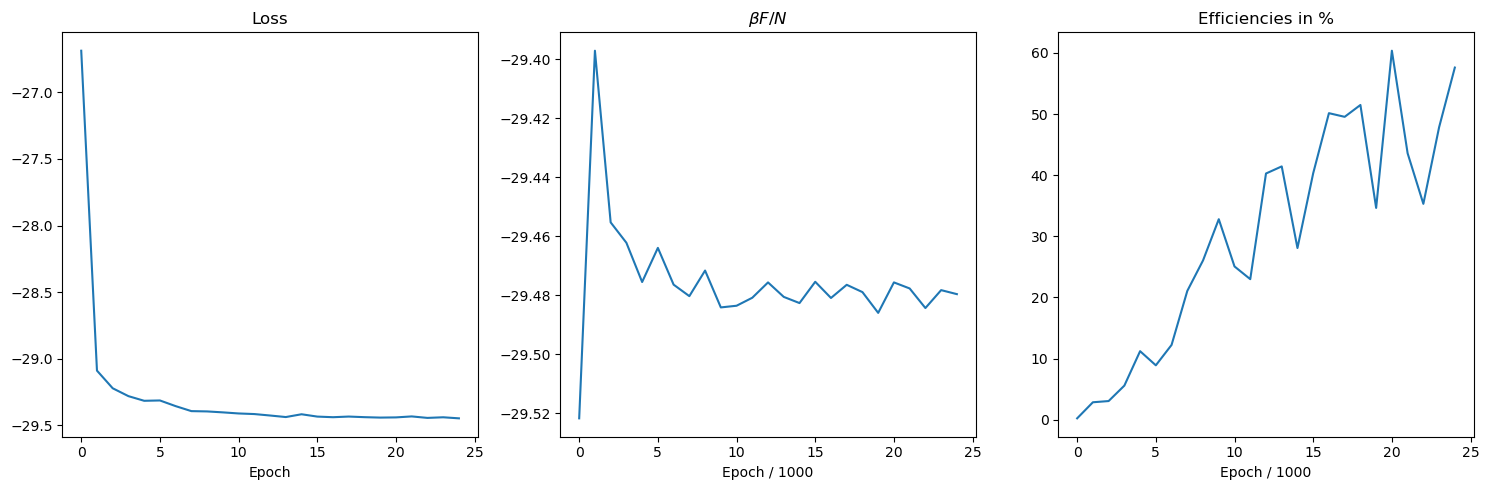

In [6]:
train(config, system, job_id=system)

## Evaluation

In [7]:
import pickle
with open(f"params/params-{system}.pkl", "rb") as fp:
    params = pickle.load(fp)



In [8]:
from ml_collections import config_dict


Here we set up how the model will be tested: how many samples to use, how many times to run it, and whether to also evaluate the marginal density.  

- **`eval_steps`** – number of evaluation runs to perform.  
- **`test_size`** – number of test samples used for each evaluation.  
- **`num_splits`** – number of data splits to use during evaluation (reduces memory).  
- **`seed`** – random seed for reproducibility, chosen randomly each run.  
- **`load_multi_gpu`** – whether to load the model on multiple GPUs for evaluation.  
- **`n_marginal`** – number of auxiliary samples drawn when estimating the marginal density.  
- **`return_marginal`** – whether to return marginal ESS and free energy estimates.  


In [9]:
config_eval = config_dict.ConfigDict()
config_eval.eval_steps=3
config_eval.test_size= 1000
config_eval.num_splits =1
config_eval.seed=np.random.randint(0,1e6)
config_eval.n_marginal=20
config_eval.return_marginal=True
# config_eval.filename=f"allegro/params-{flow_id}.pkl"
config_eval.filename=f"params/params-{system}.pkl"


In [10]:
metrics = evaluate(config, config_eval)


/srv/data/schebem94/miniconda3/envs/rigid_flows/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:118: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)
/srv/data/schebem94/miniconda3/envs/rigid_flows/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:118: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=devi

beta_f_per_particle: -29.48046875
ess: 59.742820739746094
beta_f_per_particle_marginal: -29.484418869018555
ess_marginal: 86.1250991821289


beta_f_per_particle: -29.48365020751953
ess: 40.38872146606445
beta_f_per_particle_marginal: -29.485111236572266
ess_marginal: 83.20903015136719


beta_f_per_particle: -29.482709884643555
ess: 61.33524703979492
beta_f_per_particle_marginal: -29.484281539916992
ess_marginal: 80.91742706298828




The reported free energy is not the absolute free energy, but rather the difference relative to the base distribution. The base distribution consists of harmonic oscillators centered at the ideal lattice sites, which in the materials science community is known as the *Einstein crystal*. To obtain the absolute free energy, the contribution of the Einstein crystal must be added.


In [11]:
vol = num_particles / QUIGLEY_DENSITY

In [12]:
def get_spring_constant(beta, std):
        k_EC = 1.0 / (2.0 * beta * std**2)
        return k_EC

k_EC = get_spring_constant(state.beta, config.model.kwargs.base.kwargs.noise_scale)
abs_f_ec = abs_f_einstein(n_particles = num_particles,lambda_de_broglie=MW_SIGMA,volume=vol,beta=state.beta,einstein_spring_constant=k_EC)


Now we can add the Einstein crystal contribution to the results to obtain the absolute free energy.


In [13]:
metrics["beta_f_per_particle"] + abs_f_ec, metrics["beta_f_per_particle"] + abs_f_ec

(Array(-25.867304, dtype=float32), Array(-25.867304, dtype=float32))

The reference value is $\beta F / N \approx -25.86$.

## Evaluation of trained models
Here we can evaluate a model trained at $N=216$. Reference values for the mW ice system are:

| System      | $N$  | $\beta F / N$ |
|------------|------|---------------|
| Cubic ice  | 64   | -25.163       |
| Cubic ice  | 216  | -25.082       |
| Cubic ice  | 512  | -25.062       |



In [14]:
system_train = "mw_cubic_216"
system = "mw_cubic_512"
lattice, num_particles = _extract_lattice_and_number(system)
config = augmented_monatomic_water_config.get_config(num_particles, lattice)


We need to adjust the hyperparameters to the ones used in training.

In [15]:
config.model.kwargs.bijector.kwargs.conditioner.kwargs.conditioner_kwargs.embedding_size = 96
config.model.kwargs.bijector.kwargs.conditioner.kwargs.conditioner_kwargs.n_local = 16
config.model.kwargs.bijector.kwargs.num_layers = 10

In [16]:
config_eval = config_dict.ConfigDict()
config_eval.eval_steps=1
config_eval.test_size= 1000
config_eval.num_splits =2
config_eval.seed=np.random.randint(0,1e6)
config_eval.return_marginal=False
config_eval.filename=f"params_trained/params-{system_train}.pkl"


In [17]:
metrics = evaluate(config, config_eval)


beta_f_per_particle: -29.721599578857422
ess: 1.4186639785766602
beta_f_per_particle_marginal: None
ess_marginal: None




In [18]:
k_EC = get_spring_constant(state.beta, config.model.kwargs.base.kwargs.noise_scale)


In [19]:
vol = num_particles / QUIGLEY_DENSITY
abs_f_ec = abs_f_einstein(n_particles = num_particles,lambda_de_broglie=MW_SIGMA,volume=vol,beta=state.beta,einstein_spring_constant=k_EC)
metrics["beta_f_per_particle"] + abs_f_ec

Array(-25.062037, dtype=float32)

In [20]:
from bgmat.utils.observable_utils import radial_distribution_function

In [21]:
box_length = config.test_energy.kwargs.box_length


In [22]:

generated_samples = metrics["samples_mapped"]
generated_energies = metrics["energies"]
rdf_mapped =radial_distribution_function(generated_samples, box_length=box_length)

# reference MD data
rdf_md = np.load(f"data_md/rdf_md_{system}.npy")
energies_md = np.load(f"data_md/ene_md_{system}.npy")


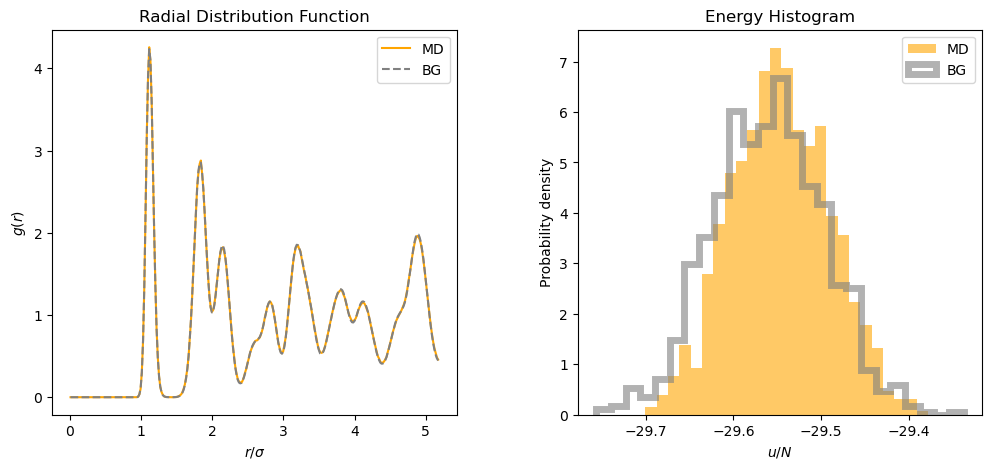

: 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

energies_md_scaled = state.beta * energies_md / num_particles
generated_energies_scaled = state.beta * generated_energies / num_particles

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# --- Left: RDF ---
ax = axes[0]
ax.plot(rdf_md[:,0] / MW_SIGMA, rdf_md[:,1], label="MD", color="orange")
ax.plot(rdf_mapped[:,0] / MW_SIGMA, rdf_mapped[:,1], label="BG", color="gray", ls="--")
ax.set_xlabel("$r / \sigma$")
ax.set_ylabel("$g(r)$")
ax.legend()
ax.set_title("Radial Distribution Function")

# --- Right: Energy histogram ---
ax = axes[1]
bins = 25  # adjust as needed
ax.hist(energies_md_scaled, bins=bins, alpha=0.6, label="MD", color="orange", density=True)
ax.hist(generated_energies_scaled, bins=bins, alpha=0.6, label="BG", color="gray", density=True, histtype="step", linewidth=5)
ax.set_xlabel(r"$u / N$")
ax.set_ylabel("Probability density")
ax.legend()
ax.set_title("Energy Histogram")
plt.subplots_adjust(wspace=0.3)
plt.show()
